In [1]:
import sys
sys.path.append('..')
from tsai.utils import *
from tsai.basics import *
from matplotlib import dates as mdates
import sklearn
my_setup(sklearn)
from swdf.utils import generate_preprocessed_data

from statsmodels.tsa.seasonal import seasonal_decompose


os              : Linux-6.8.0-41-generic-x86_64-with-glibc2.31
python          : 3.10.12
tsai            : 0.3.10
fastai          : 2.7.15
fastcore        : 1.5.49
sklearn         : 1.5.1
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 3070 Ti Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.28 GB
GPU memory      : [8.0] GB


# DST and AP Geomagnetic Indices Data Preprocessing Using Trend, Seasonality, Residual (TSR) Decomposition

This notebook uses the data that has already been preprocessed in the `geodstap_data` notebook and further processes it to obtain the **Trend, Seasonality**, and **Residual** components of the Dst and Ap time series. Studies have shown that **Recurrent Neural Network (RNN)** models, such as **LSTM**, **GRU**, or **RNN**, can improve forecasting performance when the dataset contains complex data. By filtering out the general **trend** and **seasonality** of the data, we isolate the residuals, which capture the **non-periodical** values.

The residual component is typically the most challenging to forecast, but improved performance in the trend and seasonality components can assist in better overall results. This approach allows RNN models to focus on the more **irregular** and **volatile** parts of the time series, which are often the hardest to predict.

<details>
<summary><u>References</u></summary>

- R. El Abassi, J. Idrais, A. Sabour. "Efficiency of recurrent neural networks for seasonal trended time series modelling," in International Journal of Electrical & Computer Engineering (2088-8708), vol. 13, no. 6, 2023.

- F. Piccialli, et al. "GRAPHITE — Generative Reasoning and Analysis for Predictive Handling in Traffic Efficiency," in Information Fusion, vol. 106, pp. 102265, 2024.

</details>


In [2]:
config_tsr = yaml2dict('./config/tsr_decomposition.yaml', attrdict=True).data
config_geodstap = yaml2dict('./config/geodstap.yaml', attrdict=True).data
config = AttrDict({**config_tsr, 'data': AttrDict({**config_geodstap})})
config

```json
{ 'data': { 'add_time_channels': False,
            'ap_config': './config/geoap.yaml',
            'data_columns': ['DST', 'AP'],
            'data_nb': './geodstap_data.ipynb',
            'df_save_path': './preprocessed_data/dataframes/geodstap.pkl',
            'dst_config': './config/geodst.yaml',
            'exp_pipe_save_path': './preprocessed_data/pipelines/exp_geodstap.pkl',
            'preproc_pipe_save_path': './preprocessed_data/pipelines/preproc_geodstap.pkl'},
  'data_columns': [ 'DST_Trend',
                    'DST_Seasonal',
                    'DST_Residual',
                    'AP_Trend',
                    'AP_Seasonal',
                    'AP_Residual'],
  'data_nb': './geodstap_tsr_data.ipynb',
  'df_save_path': './preprocessed_data/dataframes/geodstap_tsr.pkl',
  'exp_pipe_save_path': './preprocessed_data/pipelines/exp_geodstap_tsr.pkl',
  'preproc_pipe_save_path': './preprocessed_data/pipelines/preproc_geodstap_tsr.pkl',
  'tsa_model': 'additive'}
```

In [3]:
df_dstap, _ = generate_preprocessed_data(config.data, generate_preproc_pipe=False)

df_dstap

,Datetime,DST,AP
0,1957-01-01 00:00:00,12.000000,2
1,1957-01-01 03:00:00,9.300000,3
2,1957-01-01 06:00:00,5.000000,3
3,1957-01-01 09:00:00,-5.000000,22
4,1957-01-01 12:00:00,0.000000,15
...,...,...,...
197518,2024-08-06 18:00:00,-14.300000,5
197519,2024-08-06 21:00:00,-18.700001,6
197520,2024-08-07 00:00:00,-17.299999,4
197521,2024-08-07 03:00:00,-16.000000,6


As can be seen, the chosen period for the TSR analysis corresponds to the **approximate duration of a solar cycle**. Although a solar cycle is not an exact phenomenon, its duration can vary from one cycle to the next—this approach is ideal for this type of decomposition, where periodicity is a key requirement. 

We left the decomposition as additive due to the existence of negative values that are uncompatible with multiplicative decomposition.


In [4]:
period = int(365.25 * 8 * 11)

tsa_dst = seasonal_decompose(df_dstap['DST'], 
                             model=config.tsa_model, 
                             period=period, 
                             extrapolate_trend="freq")

print(f'DST lost data during decomposition: {tsa_dst.trend.isna().sum() + tsa_dst.seasonal.isna().sum() + tsa_dst.resid.isna().sum()}.')

DST lost data during decomposition: 0.


In [5]:
tsa_ap = seasonal_decompose(df_dstap['AP'], 
                             model=config.tsa_model, 
                             period=period, 
                             extrapolate_trend="freq")

print(f'AP lost data during decomposition: {tsa_ap.trend.isna().sum() + tsa_ap.seasonal.isna().sum() + tsa_ap.resid.isna().sum()}.')

AP lost data during decomposition: 0.


In [6]:
df_raw = pd.DataFrame({
    'Datetime': df_dstap.Datetime,
    'DST_Trend': tsa_dst.trend,
    'DST_Seasonal': tsa_dst.seasonal,
    'DST_Residual': tsa_dst.resid,
    'AP_Trend': tsa_ap.trend,
    'AP_Seasonal': tsa_ap.seasonal,
    'AP_Residual': tsa_ap.resid
}
)
df_raw

,Datetime,DST_Trend,DST_Seasonal,DST_Residual,AP_Trend,AP_Seasonal,AP_Residual
0,1957-01-01 00:00:00,-10.215581,-3.938388,26.153969,13.377429,-6.055088,-5.322341
1,1957-01-01 03:00:00,-10.215641,-4.895568,24.411209,13.377415,-5.197928,-5.179487
2,1957-01-01 06:00:00,-10.215700,-3.695611,18.911312,13.377401,-5.197962,-5.179438
3,1957-01-01 09:00:00,-10.215760,-2.881353,8.097113,13.377386,4.516296,4.106317
4,1957-01-01 12:00:00,-10.215819,-4.924216,15.140035,13.377372,6.230585,-4.607958
...,...,...,...,...,...,...,...
197518,2024-08-06 18:00:00,-10.598428,8.379153,-12.080726,7.949210,-2.072029,-0.877182
197519,2024-08-06 21:00:00,-10.598423,4.079117,-12.180695,7.949199,-4.357522,2.408322
197520,2024-08-07 00:00:00,-10.598417,3.336191,-10.037773,7.949188,-3.928775,-0.020412
197521,2024-08-07 03:00:00,-10.598412,8.136136,-13.537724,7.949177,-4.500100,2.550924


In [7]:
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrink dataframe memory usage and set the right dtypes
], verbose=True)

df = preproc_pipe.fit_transform(df_raw)
df

Initial memory usage: 10.55 MB  
Final memory usage  : 6.03 MB    (-42.9%)
[Pipeline] .......... (step 1 of 1) Processing shrinker, total=   0.0s


,Datetime,DST_Trend,DST_Seasonal,DST_Residual,AP_Trend,AP_Seasonal,AP_Residual
0,1957-01-01 00:00:00,-10.215581,-3.938388,26.153969,13.377429,-6.055088,-5.322341
1,1957-01-01 03:00:00,-10.215641,-4.895568,24.411209,13.377415,-5.197928,-5.179487
2,1957-01-01 06:00:00,-10.215700,-3.695611,18.911312,13.377400,-5.197962,-5.179439
3,1957-01-01 09:00:00,-10.215760,-2.881353,8.097114,13.377386,4.516296,4.106318
4,1957-01-01 12:00:00,-10.215819,-4.924216,15.140036,13.377373,6.230586,-4.607958
...,...,...,...,...,...,...,...
197518,2024-08-06 18:00:00,-10.598428,8.379153,-12.080726,7.949211,-2.072029,-0.877182
197519,2024-08-06 21:00:00,-10.598423,4.079117,-12.180696,7.949199,-4.357522,2.408322
197520,2024-08-07 00:00:00,-10.598417,3.336191,-10.037773,7.949188,-3.928775,-0.020412
197521,2024-08-07 03:00:00,-10.598412,8.136136,-13.537724,7.949176,-4.500100,2.550924


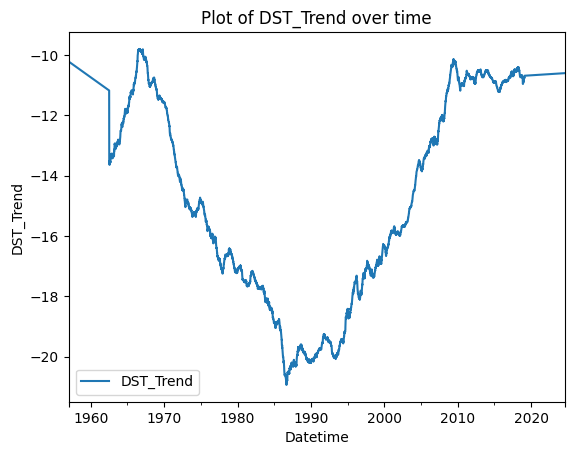

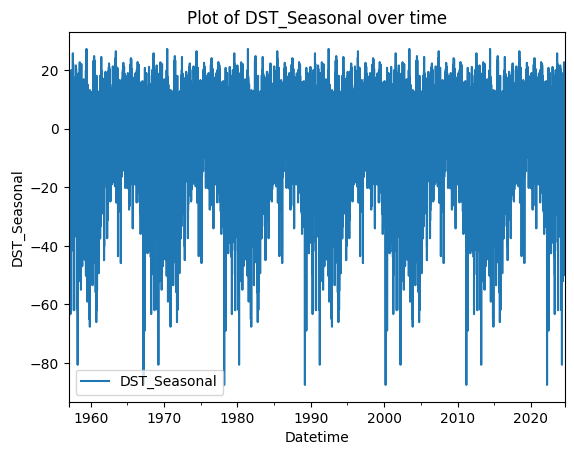

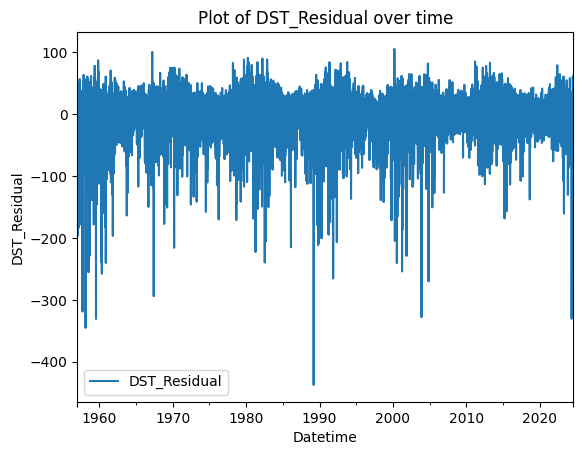

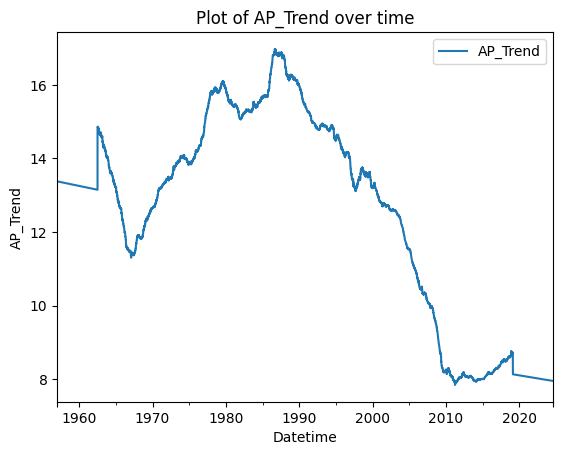

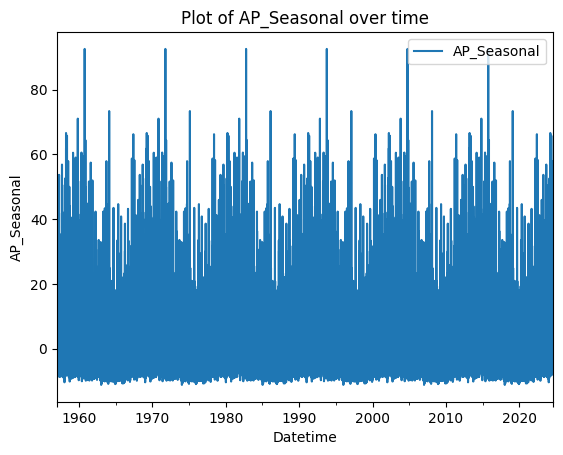

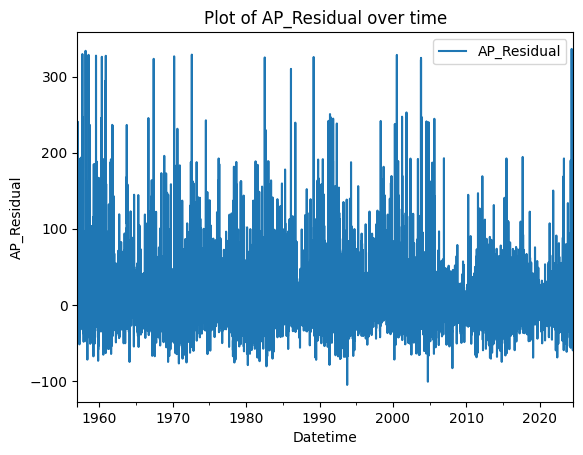

In [8]:
# Plotting each column separately
for column in df.columns[1:]:
    df.plot(x='Datetime', y=column, kind='line')
    plt.xlabel('Datetime')
    plt.ylabel(column)
    plt.title(f'Plot of {column} over time')
    plt.show()

In [9]:
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=config.data_columns)),
], verbose=True)
df_scaled = exp_pipe.fit_transform(df.copy())

df_scaled.head()

[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


,Datetime,DST_Trend,DST_Seasonal,DST_Residual,AP_Trend,AP_Seasonal,AP_Residual
0,1957-01-01 00:00:00,1.167652,-0.371893,1.319749,0.309764,-0.767110,-0.329974
1,1957-01-01 03:00:00,1.167635,-0.463402,1.233252,0.309759,-0.659058,-0.321665
2,1957-01-01 06:00:00,1.167618,-0.348682,0.960280,0.309753,-0.659062,-0.321663
3,1957-01-01 09:00:00,1.167600,-0.270837,0.423547,0.309748,0.565496,0.218418
4,1957-01-01 12:00:00,1.167583,-0.466141,0.773103,0.309744,0.781595,-0.288424


In [10]:
save_object(df, config.df_save_path)
save_object(preproc_pipe, config.preproc_pipe_save_path)
save_object(exp_pipe, config.exp_pipe_save_path)

preprocessed_data/dataframes directory already exists.
DataFrame saved as preprocessed_data/dataframes/geodstap_tsr.pkl
preprocessed_data/pipelines directory already exists.
Pipeline saved as preprocessed_data/pipelines/preproc_geodstap_tsr.pkl
preprocessed_data/pipelines directory already exists.
Pipeline saved as preprocessed_data/pipelines/exp_geodstap_tsr.pkl
